# Notebook overview

The goal of this notebook is to test feature extraction from images using Spark in the local environment.

# Imports
## Libraries


In [41]:
import pandas as pd
from PIL import Image
import numpy as np
import os, math, io
from skimage import io as skio
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split, udf
from pyspark.sql.types import ArrayType, FloatType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
from typing import Iterator

## Data

Define image paths:

In [56]:
PATH = os.getcwd()
PATH_DATA_SOURCE = f'{PATH}/data/source'
PATH_DATA_PROCESSED = f'{PATH}/data/processed'

PATH_DATA_SOURCE_TRAINING = f'{PATH_DATA_SOURCE}/Training'

print(PATH_DATA_SOURCE_TRAINING)

/Users/natche/Jupiter/Project_8/data/source/Training


In [3]:
folders_train = [f for f in os.listdir(PATH_DATA_SOURCE_TRAINING) if not f.startswith('.')]
folders_train

['cucumber_3',
 'zucchini_1',
 'eggplant_violet_1',
 'apple_red_yellow_1',
 'apple_crimson_snow_1',
 'pear_1',
 'apple_red_delicios_1',
 'apple_rotten_1',
 'apple_golden_3',
 'apple_golden_2',
 'apple_red_1',
 'carrot_1',
 'apple_granny_smith_1',
 'apple_braeburn_1',
 'cabbage_white_1',
 'cucumber_1',
 'pear_3',
 'apple_hit_1',
 'apple_golden_1',
 'apple_pink_lady_1',
 'apple_6',
 'zucchini_dark_1',
 'apple_red_2',
 'apple_red_3']

In [4]:
img_len = 0

for folder in folders_train:
    files = [f for f in os.listdir(PATH_DATA_SOURCE_TRAINING + '/' + folder) if not f.startswith('.')]
    img_len+=len(files)
    print(f'class {folder}: {len(files)} images')

print(f'Total: {img_len}')

class cucumber_3: 163 images
class zucchini_1: 160 images
class eggplant_violet_1: 160 images
class apple_red_yellow_1: 308 images
class apple_crimson_snow_1: 318 images
class pear_1: 326 images
class apple_red_delicios_1: 300 images
class apple_rotten_1: 319 images
class apple_golden_3: 316 images
class apple_golden_2: 308 images
class apple_red_1: 309 images
class carrot_1: 101 images
class apple_granny_smith_1: 320 images
class apple_braeburn_1: 320 images
class cabbage_white_1: 96 images
class cucumber_1: 100 images
class pear_3: 144 images
class apple_hit_1: 468 images
class apple_golden_1: 308 images
class apple_pink_lady_1: 313 images
class apple_6: 315 images
class zucchini_dark_1: 160 images
class apple_red_2: 318 images
class apple_red_3: 281 images
Total: 6231


**Display some images**

In [5]:
def display_images(X, y=None, columns=12, x_size=1, y_size=1, colorbar=False, y_pred=None, cmap='gray', norm=None, spines_alpha=1, interpolation='lanczos'):
    """
    Show images in a grid, with legends
    args:
        X             : images array
        y             : real classes or labels or None (None)
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1) 
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cmap          : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        spines_alpha  : Spines alpha (1.)
    returns: 
        void
    """
    
    indices = range(len(X))
        
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
        
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    padding     = 1
    fontsize    = 10
    
    fig=plt.figure(figsize=(columns * (x_size + padding), rows * (y_size + padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1

        img=axs.imshow(X[i], cmap = cmap)

        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    
    plt.show()

cucumber_3


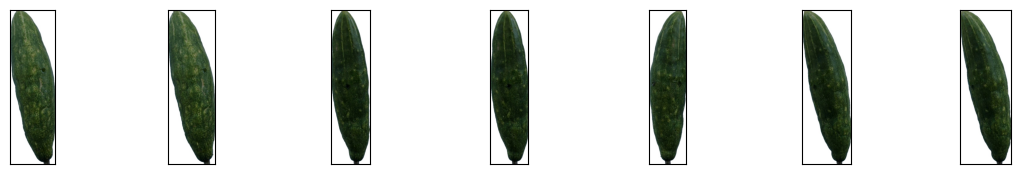

zucchini_1


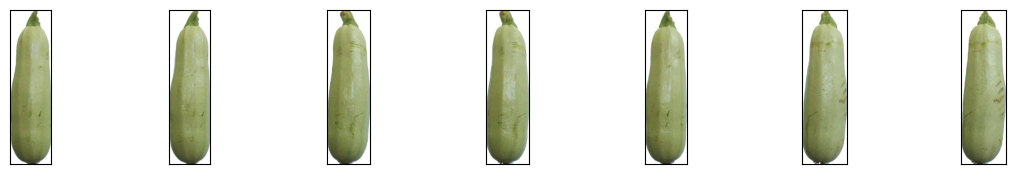

eggplant_violet_1


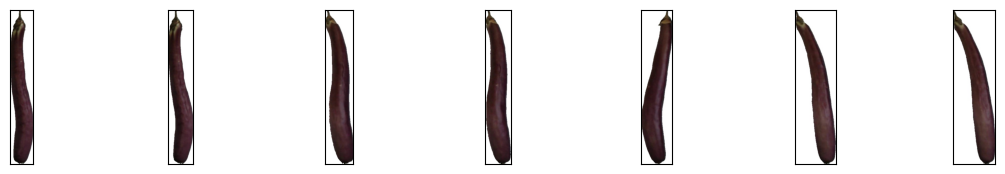

apple_red_yellow_1


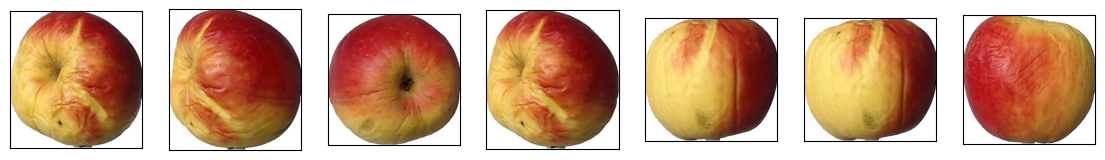

apple_crimson_snow_1


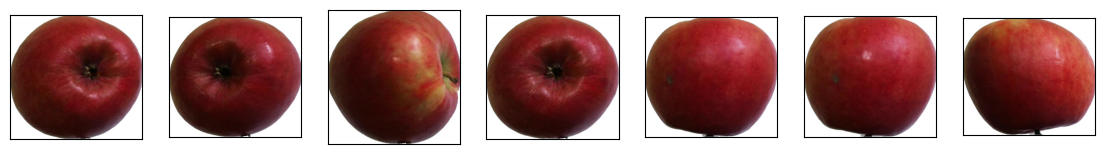

In [33]:
for folder in folders_train[:5]:
    image_folder = PATH_DATA_SOURCE_TRAINING + '/' + folder
    images = [f for f in os.listdir(image_folder) if not f.startswith('.')][:7]
    sample_images = []
    
    # read images
    for image in images:
        image = skio.imread(image_folder + '/' + image)
        sample_images.append(image)

    print(folder)
    display_images(X=sample_images, columns=7, x_size=1, y_size=1)

# PySpark
## Init Spark
**Create SparkSession**

SparkSession is a unified entry point for Spark applications. It acts as a connector to all Spark’s underlying functionalities, including RDDs, DataFrames, and Datasets, providing a unified interface to work with structured data processing.

In [10]:
SparkSession

pyspark.sql.session.SparkSession

In [18]:
spark = (SparkSession
         .builder
         .appName('SparkP8')
         .master("local[*]")
         .config("spark.sql.parquet.writeLegacyFormat", 'true')
         .getOrCreate()
)

**Create SparkContext**

In [19]:
sc = spark.sparkContext

In [20]:
sc

<SparkContext master=local[*] appName=SparkP8>

## Load data with Spark

**Training**

In [21]:
train_images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_DATA_SOURCE_TRAINING)

Extract labels and add them to the dataframe

In [15]:
train_images_with_labels = train_images.withColumn('label', element_at(split(train_images['path'], '/'),-2))
print(train_images_with_labels.printSchema())
print(train_images_with_labels.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------------------------------------------+-----------+
|path                                                                            |label      |
+--------------------------------------------------------------------------------+-----------+
|file:/Users/natche/Jupiter/Project_8/data/source/Training/apple_hit_1/r0_116.jpg|apple_hit_1|
|file:/Users/natche/Jupiter/Project_8/data/source/Training/apple_hit_1/r0_114.jpg|apple_hit_1|
|file:/Users/natche/Jupiter/Project_8/data/source/Training/apple_hit_1/r0_108.jpg|apple_hit_1|
|file:/Users/natche/Jupiter/Project_8/data/source/Training/apple_hit_1/r0_118.jpg|apple_hit_1|
|file:/Users/natche/Jupiter/Project_8/data/source/Training/apple_hit_1/r0_120.jpg|apple_hit_1|
+-----------------------------

# Model
## Load MobileNetV2

We will instantiate the base model with the following parameters:

- weights: 'imagenet'
- include_top: False -> keep only convolutional layers as we will include the specific layers for the classification
- input_shape: (224, 224, 3)
- pooling: 'avg', optional pooling mode for feature extraction when include_top is False. avg means that global avg pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor
  
It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training.

In [22]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

# Freeze existing MobileNetV2 already trained weights
base_model.trainable = False
mobilenet_model = Model(inputs=base_model.inputs, outputs=base_model.output)
mobilenet_weights = mobilenet_model.get_weights()

# Broadcast the weights
broadcast_mobilenet_weights = spark.sparkContext.broadcast(mobilenet_weights)

In [ ]:
mobilenet_model.summary()

In [23]:
def create_model():
    base_model = MobileNetV2(weights='imagenet',
                    include_top=False,
                    input_shape=(224, 224, 3),
                    pooling='avg')

    # Freeze existing MobileNetV2 already trained weights
    base_model.trainable = False

    model = Model(inputs=base_model.inputs, outputs=base_model.output)
    
    # Use the broadcasted weights
    mobilenet_model.set_weights(broadcast_mobilenet_weights.value)
    
    return model

# Feature extraction

Split the feature extraction process in several functions:

In [25]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    
    return preprocess_input(arr)

In [26]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    
    return pd.Series(output)

Pandas UDF (User-Defined Function) refers to a feature in Apache Spark that allows you to apply a user-defined function using the pandas library on Spark DataFrames. It provides a convenient way to leverage the power and expressiveness of pandas functions when working with Spark DataFrames.

In [27]:
@pandas_udf(ArrayType(FloatType()))
def featurize_udf(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = create_model()
    
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

Apply `featurize_udf` function to the images dataframe using `repartition` method which is used to control the distribution of data across partitions. Partitions are the basic units of parallelism in Spark, and they allow data processing to be distributed across multiple executor nodes in a cluster. This can be useful for improving parallelism and optimizing data processing.

In [28]:
features_df = train_images_with_labels.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

features_df

DataFrame[path: string, label: string, features: array<float>]

## Reduce dimensions

Convert features to dense vector before proceeding with PCA.

In [34]:
to_vector_udf = udf(lambda features: Vectors.dense(features), VectorUDT())
features_df = features_df.withColumn("features_vector", to_vector_udf("features"))

In [40]:
features_df.select('features_vector').show(2, True)

1/1 [==============================] - 0s 331ms/step                (0 + 1) / 1]
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


+--------------------+
|     features_vector|
+--------------------+
|[0.38751390576362...|
|[0.09166139364242...|
+--------------------+
only showing top 2 rows



Perform PCA

In [ ]:
pca = PCA(k=50, inputCol="features_vector", outputCol="pca_features")
pca_model = pca.fit(features_df)
df_pca = pca_model.transform(features_df)

In [43]:
df_pca.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vector: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



## Store the extracted features

Store processed features in data/processed folder in 'parquet' format. Parquet is a columnar storage file format optimized for use with big data processing frameworks. It is designed to provide efficient and compressed storage of structured and semi-structured data, making it well-suited for analytics and data processing workloads. 

In [ ]:
df_pca.write.mode("overwrite").parquet(PATH_DATA_PROCESSED)

## Load stored features

In [51]:
df_processed = pd.read_parquet(PATH_DATA_PROCESSED, engine='pyarrow')
df_processed.head()

,path,label,features,features_vector,pca_features
0,file:/Users/natche/Jupiter/Project_8/data/sour...,apple_hit_1,"[0.26148897, 0.06472473, 2.1941779, 0.0, 0.289...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
1,file:/Users/natche/Jupiter/Project_8/data/sour...,apple_hit_1,"[0.19633865, 0.40195894, 1.551473, 0.0, 0.0, 0...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
2,file:/Users/natche/Jupiter/Project_8/data/sour...,apple_hit_1,"[0.17203541, 0.09680367, 1.288094, 0.0, 0.4808...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
3,file:/Users/natche/Jupiter/Project_8/data/sour...,apple_hit_1,"[0.23520221, 0.8630738, 1.8175206, 0.0, 0.3323...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
4,file:/Users/natche/Jupiter/Project_8/data/sour...,apple_hit_1,"[0.12522192, 0.3049216, 1.4363027, 0.0, 0.0964...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."


Check that the vector size is 1280

In [52]:
df_processed.loc[0,'features'].shape

(1280,)

In [53]:
df_processed.loc[0,'pca_features']

{'type': 1,
 'size': None,
 'indices': None,
 'values': array([ 6.21064558, -1.76766095,  2.27367821,  0.96082795,  3.93285972,
         8.25221661,  1.43584507, -0.50899164,  2.68377005,  2.60436557,
        -0.75456358,  6.99065068, -4.18233421,  2.46446804, -0.32108382,
         2.69863336, -3.15914762,  3.59925772,  6.03527782,  0.20463606,
         0.04896477, -2.20134257, -1.56181465, -3.01403353,  2.58054947,
        -1.92363138,  3.2193521 ,  1.32286787, -0.18166704, -4.11930795,
        -0.20949519,  1.84784987, -1.07594314, -2.2060424 , -2.55365393,
         4.96126744,  0.14578779, -0.91036257,  4.18157495,  0.07853324,
        -1.19203856,  1.07696201,  1.36146197,  1.59784542,  1.44073223,
         1.28875319,  2.1672788 ,  1.64355561,  0.70483448, -1.54525219])}

In [55]:
len(df_processed.loc[0,'pca_features']['values'])

50